In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#



# Broadband 80 Meter Antenna Ideas (Continued)

In the previous notebook we got surprisingly close to achieving coverage of the entire 80m band with a simple dipole and a properly-selected matching network: the best example provided VSWR < 2.3 across the band.

Earlier notebooks provide examples of designing cage dipoles to increase bandwidth, and in particular using a 'cage' for only a portion of the antenna's length (the remainder being a single wire) to effect a tradeoff between bandwidth and the amount of wire used.
* 020_Intro_to_Optimization.ipynb
* 030_Optimization_With_Constraints.ipynb

Based on previous results I'm going to choose a 'cage' consisting of two wires (so really just a pair of parallel wires) as being the most wire-efficient design.

The problem will be set up as a multi-objective optimization problem, which should provide us with a range of tradeoffs between our two objectives, **minimize maximum VSWR within the band** and **minimize total wire used**.

Saving a bit of wire might not be at the head of anyone's list of concerns...anyway, it provides an example of a simulation that requires the user to choose a trade-off between two objectives...

Thanks to the folks at the Pymoo project ("Python Multi-objective Optimization") for the underlying optimization code.

<img src="../Cad/Series_Section_Match_4.svg" alt="Drawing" style="width: 600px;"/>


In [1]:

#
# A reusable base class for problems similar to this one
#
# For each design it searches for the optimum series-section matching network to minimize max VSWR in the band of interest
# This is slow-ish but not a problem for a simple scenario like this one...
# The notebook '041_Series_Match_Ludicrous_Mode.ipynb' shows how to do the scanning on a GPU if you're so inclined.
#
# You'll need to define the function _make_design() to 'draw' the geometry of your antenna based on the parameters
#  that the optimizer gives you.
#
# Also provide the function _compute_results() to specify the objectives, constraints, and other data to be saved
#  for each design
#




import numpy as np
from pymoo.core.problem import Problem
from necutil import nec5_sim_stdio3, make_linear_element, gen_nec5_str, plot_vswr_2
from necutil import wire_ant_visualize, rot_x, rot_y, translate, make_cage_element, total_wire_len
from necutil import series_match_precompute, series_match_scan

class DipoleSSMProblem(Problem):
    # n_var, n_obj, n_ieq_constraints       #variables (design parameters), #objectives, #inequality constraints
    # segs_per_m                            segments per meter when generating NEC cards
    # radius, z                             wire radius (m), height above ground (m)
    # f_min, f_max, f_num                   freq band of interest, #freq points within band
    # z0a, z0b                              impedances of series-section-matching TLs
    def __init__(self, n_var, n_obj, n_ieq_constr, segs_per_m, radius, f_min, f_max, z, f_num=9, z0a=50, z0b=75, **kwargs):
        super().__init__(n_var=n_var,
                         n_obj=n_obj,
                         n_ieq_constr=n_ieq_constr,
                         **kwargs)

        # Save some problem characteristics
        self.f_min = f_min              # Frequency band of interest: min, max, # of points
        self.f_max = f_max
        self.f_num = f_num        
        self.freqs = np.linspace(f_min, f_max, num=f_num)       # Freqs of interest as an array
        self.f_center = np.mean([f_min,f_max])                  # Center freq
        self.z0 = 50                    # TL impedance
        self.z = z                      # z dimension (height of antenna)
        self.segs_per_m = segs_per_m    # NEC segments per meter 
        self.radius = radius            # Wire radius (m)

        # Precompute some arrays (speeds process of scanning for optimum matching network)
        self.A,self.B,self.C,self.D = series_match_precompute(zoa=z0a,zob=z0b,nfreq=f_num,flow=f_min,fhigh=f_max)
        
        # NEC5 design deck template
        # GX: mirror across xz plane
        # EX: feedpoint specified as tag=1, segment=1, near end (1)
        # GD: Some typical MININEC ground parameters
        self.necpre = 'CE Dipole\n'             # Obligatory comment line
        self.necpost = f"""GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {f_num} 0 0 {f_min} {(f_max-f_min)/(f_num-1)}
XQ 0
EN
"""
 

    # Optimization algorithms call this entry point with a population of designs
    #   X       an array of design parameters of shape (population_size, number_of_variables)
    #   out     dictionary where we'll return our results
    def _evaluate(self, X, out, *args, **kwargs):

        # Write a custom _make_design() for your problem
        # Use the params in x to create the design as a list of numpy arrays (see details in '010_Wire_Antennas.ipynb')
        designs = [self._make_design(x) for x in X]                 # Make antenna designs based on params in X

        # Turns your design into an NEC deck using the template
        necdecks = [self.necpre + gen_nec5_str(d, self.segs_per_m, self.radius) + self.necpost for d in designs]     # Convert to NEC decks (strings)

        res = nec5_sim_stdio3(necdecks, timelimit=10000.0)          # Run the simulations

        # Extracts feedpoint complex z for each design --> complex array of shape (#designs, #freqs)
        zs = np.array([[freq[1] for freq in des[0][0]] for des in res])

        # Scan for optimum series matching segment lengths (degrees) for each design
        # We're checking all lengths of [0, 180] degrees for both z0a, z0b segments
        a_b = np.empty((zs.shape[0],2))
        vswr_curves = np.empty(zs.shape)
        max_vswr = np.empty((zs.shape[0],1))
        for idx in range(zs.shape[0]):
            aopt,bopt,vswr_curve_opt,vswr_max_opt = series_match_scan(zs[idx:idx+1], self.A,self.B,self.C,self.D, z0=self.z0)
            a_b[idx,:] = (aopt,bopt)
            vswr_curves[idx,:] = vswr_curve_opt
            max_vswr[idx,:] = vswr_max_opt

        
        # Write a custom function to return objectives, constraints, other values
        self._compute_results(X, out, designs, zs, a_b, vswr_curves, max_vswr)




In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize


# A simple linear scaling class:
#  We want to scale our objectives to be of similar sizes
class ObjectiveScaler:
    def __init__(self,xl,xh,scaledl,scaledh):
        self.m = (scaledh-scaledl)/(xh-xl)
        self.b = scaledl - self.m*xl
    def scale(self, X):
        return self.m*X + self.b
    def unscale(self, X):
        return (X - self.b) / self.m
    

#
# The class representing our specific problem
#
class OptCageSSMProblem(DipoleSSMProblem):
    # (2) variables:  overall length (of half-element), length of 'cage' portion (as fraction of element length)
    # (2) objectives to minimize: max VSWR within band, total wire length used
    # (1) constraint: max vswr <= 2.0
    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, **kwargs)

        # Create scaler objs to scale our objectives to approx [0.0, 1.0] ranges
        self.vswr_scaler = ObjectiveScaler(1.0, 2.0, 0.0, 1.0)          # VSWRs from 1.0 - 2.0
        self.wlen_scaler = ObjectiveScaler(20.0, 40.0, 0.0, 1.0)        # Range of wire lengths 20 - 40m (?)


    # Your custom function to construct the antenna
    # See '010_Wire_Antennas.ipynb' for more details
    # Design params: 
    #   x[0]    overall length
    #   x[1]    length of 'cage' portion as fraction of overall length
    def _make_design(self, x):
        half_el = make_linear_element((0,0,0),(0,0.5,0))                        # Initial 0.5m straight wire section
        half_el.extend( make_cage_element(0.5, x[0]*x[1]+0.5, .2, .5, 2) )      # 2 wires, 1m apart
        half_el.extend( make_linear_element((0,x[0]*x[1]+0.5,0),(0,x[0],0)) )   # Straight wire for remainder of element
        half_el = rot_y(half_el, np.pi/2)               # Rotate 90deg so wires are in horizontal plane
        half_el = translate(half_el, (0,0,self.z))      # Move to 'z' meters above ground
        return half_el


    # Your custom function to return objectives, constraints, other values
    def _compute_results(self, X, out, designs, zs, a_b, vswr_curves, max_vswr):

        #
        # Our objectives to minimize are:  max vswr in band, total wire length used
        #
        total_wl =  np.array([total_wire_len(des) for des in designs])[:,None]      # Wire lengths as column vector
        out['F'] = [self.vswr_scaler.scale(max_vswr), self.wlen_scaler.scale(total_wl)]         # Return objs as a list of column vectors

        # Constraint: max vswr must be <= 2.0
        out['G'] = max_vswr - 2.0               # Constraint satisfied if <= 0
        
        # Can attach any other data to population of designs
        #  Not used in optimization, but can be examined later...
        out['VSWR'] = vswr_curves               # VSWR values across freq band
        out['AB'] = a_b                         # Lengths (degrees) of 'z0a' and 'z0b' matching sections
        


AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
SEGS_PER_M = 10/20.0                    # NEC segments: around 10 for the half-element
ocproblem = OptCageSSMProblem(f_min=3.5, f_max=4.0, z=30,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([17.0, 0.1]),                   # Lower, upper limits of parameters:
                                xu=np.array([23.0, 1.0]))                   # Overall len [17.0, 23.0], cage fraction [0.1, 1.0]
# Pymoo provides a variety of termination conditions
# For simplicity's sake we will just run for 50 generations
termination = get_termination("n_gen", 50)  

# Algorithm: Multi-objective genetic algorithm
algorithm = NSGA2(pop_size=200, n_offsprings=100)
# Run
res = minimize(ocproblem, algorithm, termination, save_history=False, verbose=True)





n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      8 |  0.000000E+00 |  4.5653021484 |             - |             -
     2 |      300 |     12 |  0.000000E+00 |  0.9587283224 |  0.0293239689 |             f
     3 |      400 |     10 |  0.000000E+00 |  0.3131845042 |  0.0479278864 |             f
     4 |      500 |     13 |  0.000000E+00 |  0.0998754240 |  0.0431377270 |             f
     5 |      600 |     18 |  0.000000E+00 |  0.0051773550 |  0.0052204957 |         ideal
     6 |      700 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0041918283 |         ideal
     7 |      800 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0255826437 |         nadir
     8 |      900 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0219319099 |             f
     9 |     1000 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0018452997 |             f
    10 |     1100 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0110788108 |             f

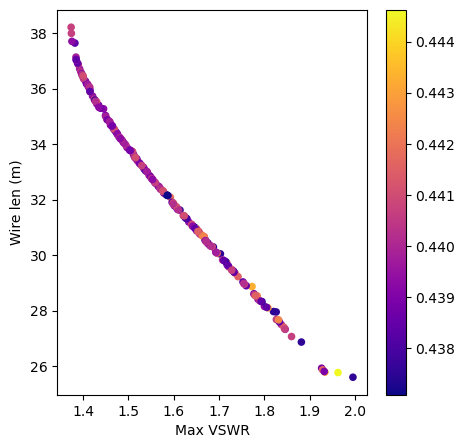

In [3]:

#
# Create a plot showing max-vswr vs. total-wire-length tradeoff
# Color scale = total loss in matching lines (dB)
#

# Un-scale the objective values
max_vswr = ocproblem.vswr_scaler.unscale(res.F[:,0:1])
total_wl = ocproblem.wlen_scaler.unscale(res.F[:,1:2])

# Compute total matching network loss (dB) (although it doesn't vary much in this problem...)
tl_loss = np.sum(res.pop.get('AB') * (299.792458 / 3.75 / 360.0) * np.array([[0.66, 0.82]]) * np.array([[1.233/100, 0.737/100]]), axis=1)[:,None]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
pts = ax.scatter(max_vswr, total_wl, c=tl_loss, s=20, cmap='plasma')

ax.set_xlabel('Max VSWR')
ax.set_ylabel('Wire len (m)')
fig.colorbar(pts)
plt.show()


In [4]:
#
# Look at detailed results as a data frame
#
import pandas as pd
df = pd.DataFrame(np.hstack([res.X, max_vswr, total_wl, tl_loss, res.pop.get('AB')]),
                   columns=['Overall len (m)', 'Cage fraction', 'Max VSWR','Wire Len (m)', 'Loss (dB)', 'A (deg)', 'B (deg)'])
df


,Overall len (m),Cage fraction,Max VSWR,Wire Len (m),Loss (dB),A (deg),B (deg)
0,20.764816,0.167766,1.995432,25.602507,0.437554,179.0,85.0
1,19.979669,0.844769,1.373778,38.211940,0.440650,177.0,90.0
2,21.033181,0.213080,1.881721,26.869007,0.437554,179.0,85.0
3,20.814565,0.180581,1.926366,25.927351,0.438896,179.0,86.0
4,20.753277,0.176483,1.962435,25.769938,0.444623,174.0,97.0
...,...,...,...,...,...,...,...
195,21.824770,0.377483,1.623457,31.417305,0.441062,175.0,93.0
196,21.885976,0.392940,1.599236,31.839912,0.440185,176.0,91.0
197,21.921504,0.412364,1.576250,32.315203,0.441062,175.0,93.0
198,21.925614,0.404883,1.585807,32.156986,0.437089,178.0,86.0


In [9]:
#
# Let's look at designs with max VSWR near 1.60:
#
# df[ (df['Max VSWR'] > 1.58) & (df['Max VSWR'] < 1.62) ].sort_values('Wire Len (m)')

# Find design with max vswr closest to 1.60
row = np.argmin(np.abs(df['Max VSWR'] - 1.60))
df.iloc[row]

Overall len (m)     21.885976
Cage fraction        0.392940
Max VSWR             1.599236
Wire Len (m)        31.839912
Loss (dB)            0.440185
A (deg)            176.000000
B (deg)             91.000000
Name: 196, dtype: float64

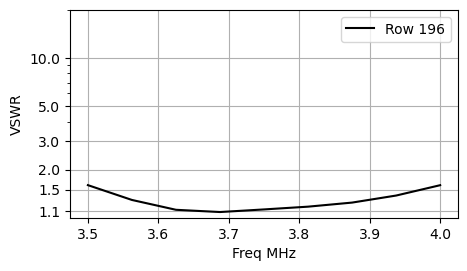

In [11]:
fvpairs = list(zip(ocproblem.freqs, res.pop.get('VSWR')[row]))   # Combine frequencies and VSWR values
plot_vswr_2([fvpairs], tags=[f'Row {row}'])

In [12]:
design = ocproblem._make_design(res.X[row])
wire_ant_visualize(design,(-22,22),(-22,22),(0,45))


Result:  Overall element length 21.9m, cage section 8.6m

If you're running this notebook locally the viewer in the previous cell will allow you to rotate, zoom, etc.
Here's a static image if you're viewing on github:

![Graph](img/Cage_051.png)

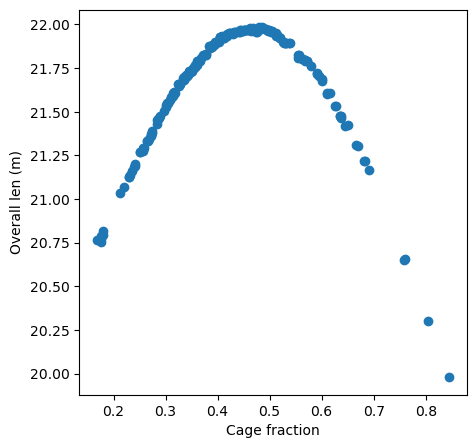

In [13]:

#
# Relationship between cage fraction and overall length seems a little funny, no?
# Something to do with current distribution along element, I guess?
#
fig, ax = plt.subplots(figsize=(5, 5))
pts = ax.scatter(df['Cage fraction'], df['Overall len (m)'])

ax.set_xlabel('Cage fraction')
ax.set_ylabel('Overall len (m)')
plt.show()


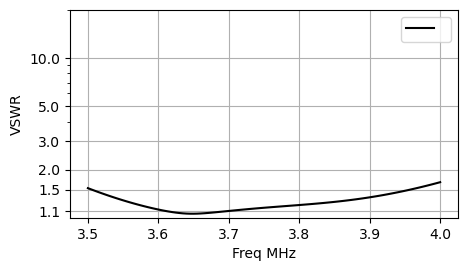

In [25]:

#
# Do a sanity check by hand-coding an NEC5 deck for the preferred solution (max vswr = 1.60)
#  using substantially more NEC segments and a finer-grain VSWR plot...
#

# Overall len (m)     21.885976
# Cage fraction        0.392940     --> 8.6m
# Max VSWR             1.599236
# A (deg)            176.000000     --> 39.084m @ 3.75 MHz (VF not considered)
# B (deg)             91.000000     --> 20.21m

necstr_tl = """CE Dipole
GW 1 1 0 0 30 0 0.5 30 0.000814
GW 2 1 0 0.5 30 -0.5 0.7 30 0.000814
GW 3 1 0 0.5 30 0.5 0.7 30 0.000814
GW 4 20 -0.5 0.7 30 -0.5 8.9 30 0.000814
GW 5 20 0.5 0.7 30 0.5 8.9 30 0.000814
GW 6 1 -0.5 8.9 30 0 9.1 30 0.000814
GW 7 1 0.5 8.9 30 0 9.1 30 0.000814
GW 8 20 0 9.1 30 0 21.89 30 0.000814
GW 20 1 0 0 2 0 0.001 2 0.001
GW 30 1 0 0 1 0 0.001 1 0.001
GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
TL 1 -1 20 -1 50 39.084 0 0 0 0
TL 20 -1 30 -1 75 20.21 0 0 0 0
EX 4 30 1 1 1.0 0.0
FR 0 {fnum} 0 0 {flow} {fstep}
XQ 0
EN
"""

from necutil import plot_vswr,find_vswr_bw
res = nec5_sim_stdio3([necstr_tl.format(fnum=101, flow=3.5, fstep=0.005)])
zs = res[0][0][0]         # freqs, zs
plot_vswr([zs], tags=[''])

#
# -->  Confirms the earlier result...increasing segments caused a slight downward frequency shift...
#


In [26]:


bw = find_vswr_bw(necstr_tl, 2.0, 3.0, 4.5, fnum=11, tol=0.001)
print(f'Bandwidth for VSWR <= 2.0 (MHz): {bw:.3f}')


Bandwidth for VSWR <= 2.0 (MHz): 0.621
